In [18]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as const
from gascooling.accommodation.evaluation.experiment import influx
from materials import silicon, teflon
from scipy import optimize

plt.style.use("seaborn-poster")

pd.set_option("display.max_rows", 100)

data = influx.get_data(
    start="2022-10-12T11:40:00Z",
    stop="2022-10-14T23:19:21Z",
    field="T-testmass",
    measurement="second run",
).rename(columns={"Temperature_Testmass_(K)": "T-testmass"})

/var/folders/3s/qbq75nf96fv6fzzvfq22l1nm0000gn/T/ipykernel_8960/4140833982.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


In [19]:
temp_tm = data.set_index("_time")
starting_timestamp = temp_tm.index[0]
temp_tm["seconds"] = (
    pd.to_datetime(temp_tm.index.to_series()) - temp_tm.index[0]
).dt.total_seconds()
temp_tm = temp_tm.set_index("seconds")

<AxesSubplot: xlabel='seconds', ylabel='TM temperature (K)'>

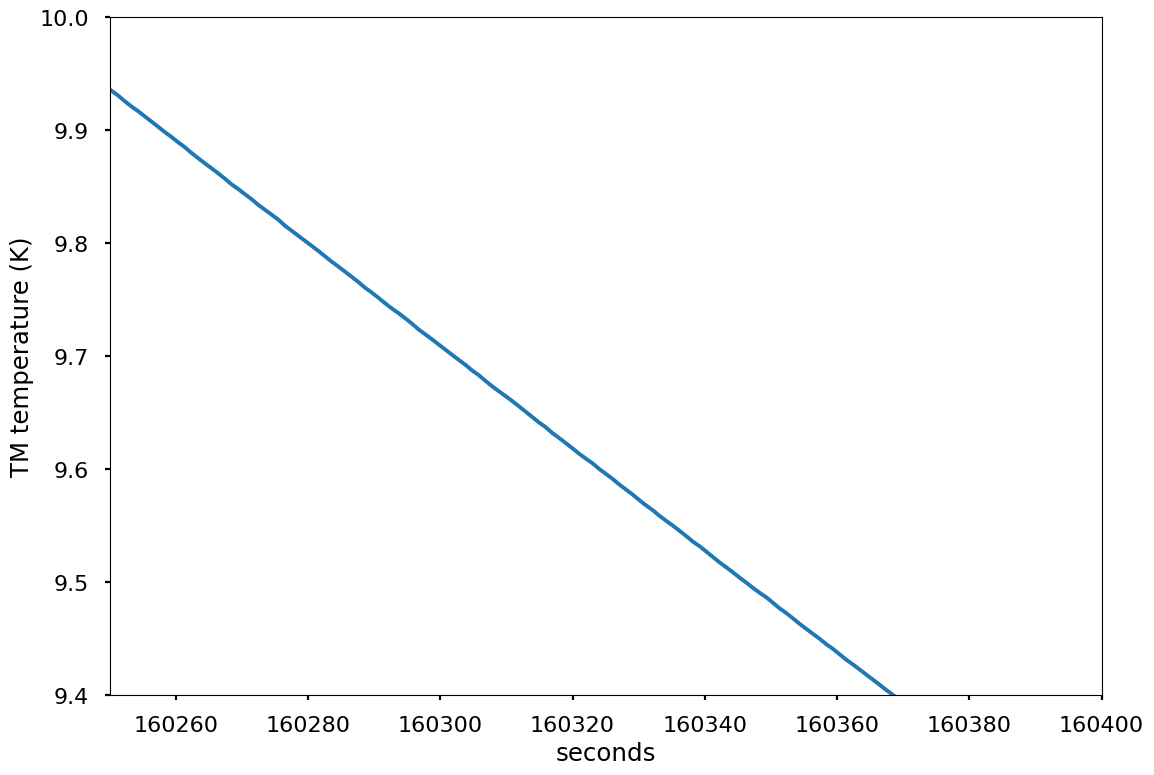

In [35]:
temp_tm["T-testmass"].plot(ylabel="TM temperature (K)", ylim=(9.4, 10), xlim=(160250, 160400))

In [7]:
display(temp_tm)

_time
2023-01-10 11:00:00.725471+00:00    292.842
2023-01-10 11:00:01.803230+00:00    292.844
2023-01-10 11:00:02.888178+00:00    292.838
2023-01-10 11:00:07.371029+00:00    292.841
2023-01-10 11:00:08.442094+00:00    292.843
                                     ...   
2023-01-10 13:51:55.562711+00:00    282.005
2023-01-10 13:51:56.645543+00:00    281.977
2023-01-10 13:51:57.762089+00:00    281.985
2023-01-10 13:51:58.842623+00:00    281.980
2023-01-10 13:51:59.918162+00:00    281.979
Name: T-testmass, Length: 8423, dtype: float64

# Heat flux out of the test mass

## Measurement during cool down (no laser is heating)
The test mass has a weight of 
m = 118 g

The heat flux is given by
$$P_\text{heating}  = \frac{\partial Q}{\partial t} \approx m\frac{\partial }{\partial t}\big\{ c(T) \cdot T(t) \big\}
= m\frac{\partial c(T) }{\partial t} \cdot T(t) + mc(t) \frac{\partial T(t)}{\partial t}
$$

with the temperature dependent specific heat capacity $c(T)$

_time
2023-01-10 11:00:00.725471+00:00    292.842
2023-01-10 11:00:01.803230+00:00    292.844
2023-01-10 11:00:02.888178+00:00    292.838
2023-01-10 11:00:07.371029+00:00    292.841
2023-01-10 11:00:08.442094+00:00    292.843
                                     ...   
2023-01-10 13:51:55.562711+00:00    282.005
2023-01-10 13:51:56.645543+00:00    281.977
2023-01-10 13:51:57.762089+00:00    281.985
2023-01-10 13:51:58.842623+00:00    281.980
2023-01-10 13:51:59.918162+00:00    281.979
Name: T-testmass, Length: 8423, dtype: float64

,T-testmass,specific heat,specific heat derivated,total heat flux (W)
seconds,,,,
0.000000,292.842,NaN,NaN,NaN
1.077759,292.844,706.709404,NaN,NaN
2.162707,292.838,706.706877,-0.002329,0.234201
6.645558,292.841,706.704982,-0.000423,0.042511
7.716623,292.843,706.708140,0.002949,-0.296547
...,...,...,...,...
10314.837240,282.005,692.894252,0.001178,-0.113898
10315.920072,281.977,692.885225,-0.008337,0.805943
10317.036618,281.985,692.872329,-0.011550,1.116565


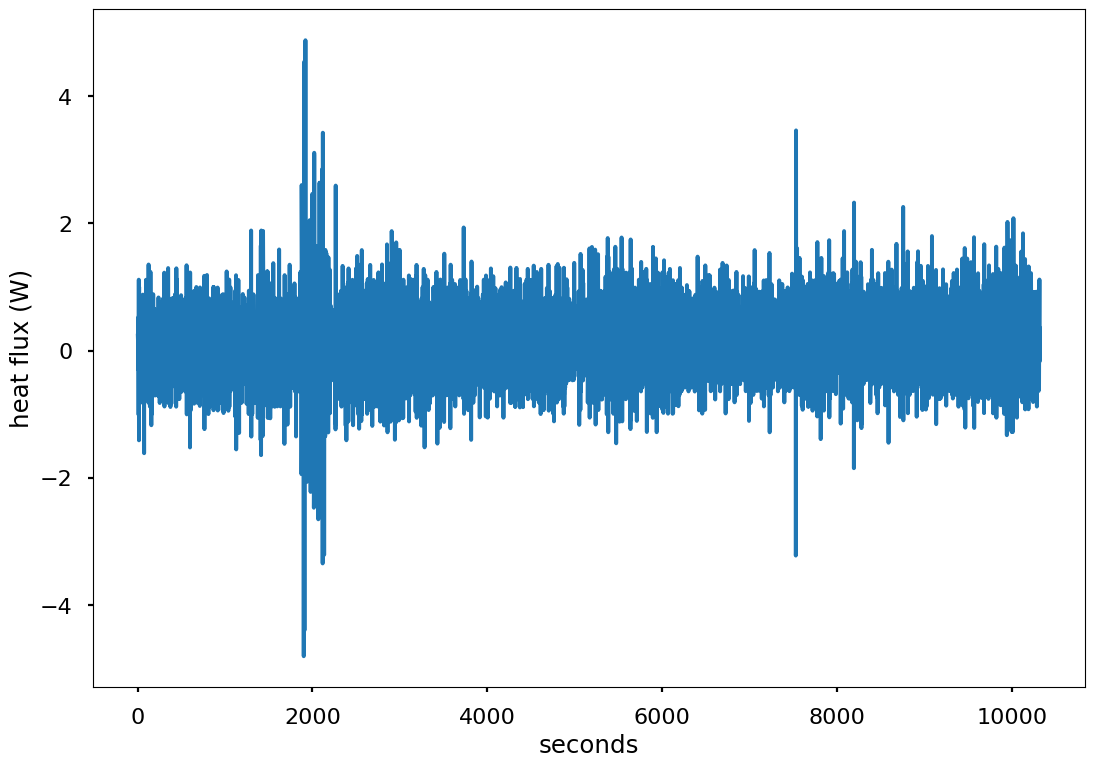

In [10]:
def derivate(quantity, derivate_by):
    return quantity.diff() / derivate_by.diff()


si = silicon.Silicon()

pd.set_option("display.max_rows", 500)

testmass = temp_tm.to_frame()
testmass["T-testmass"] = testmass["T-testmass"]
display(testmass["T-testmass"])
# print((testmass.index[0]-testmass.index[1]).total_seconds())
starting_timestamp = testmass.index[0]
testmass["seconds"] = (
    pd.to_datetime(testmass.index.to_series()) - testmass.index[0]
).dt.total_seconds()

# testmass['time'] = pd.timedelta(testmass['timestamps'], testmass['timestamps'] [0])

# pd.to_timedelta(testmass.index.dt.time.astype(str)).dt.total_seconds()
# testmass["time (s)"] = (testmass.index - starting_timestamp).total_seconds()
# testmass = testmass.set_index("time (s)")
# display(testmass)
# testmass["T-testmass"].plot()
rolling_average_number = 2
# testmass["T-testmass"] = temp_tm
testmass = testmass.set_index("seconds")
temperatures = testmass["T-testmass"].rolling(window=rolling_average_number).mean()
time_series = testmass.index.to_series()
testmass["specific heat"] = si.specific_heat(temperatures)
testmass["specific heat derivated"] = derivate(testmass["specific heat"], time_series)
testmass["total heat flux (W)"] = -0.118 * (
    si.specific_heat(temperatures) * derivate(temperatures, time_series)
    + temperatures * testmass["specific heat derivated"]
)
# testmass["total heat flux (W) average"] = testmass["total heat flux (W)"].rolling(window=1000).mean()
cooling_rate = testmass.set_index("T-testmass")
# initial_guesses =[-8,-68700,-2e9, -0.01]
initial_guesses = [-8, 0.05, 900, 3e5, 1e9]
# popt, pcov = optimize.curve_fit(
#     cooling_rate_fit,
#     cooling_rate.index[rolling_average_number:],
#     testmass["total heat flux (W)"].iloc[rolling_average_number:],
#     p0=initial_guesses,
#     # bounds=([-9, 0, 10, 5e3, 1], [-6, 0.1, 3000, 1e6, 1e10]),
# )
# testmass.loc[82290:82310]
testmass["total heat flux (W)"].plot(ylabel="heat flux (W)")
# (temperatures * derivate(testmass["specific heat"], time_series)).plot()
# testmass["total heat flux (W)"].plot()
# plt.plot(xdata_fit, cooling_rate_fit(xdata_fit, *initial_guesses))
# cooling_rate["fitted heat flux (W)"] = cooling_rate_fit(cooling_rate.index, *popt)
# cooling_rate["total heat flux (W)"].plot()
# cooling_rate["fitted heat flux (W)"].plot()
# print(cooling_rate_fit(8, *initial_guesses))
testmass

,specific heat,specific heat derivated,total heat flux (W)
T-testmass,,,


ValueError: `ydata` must not be empty!

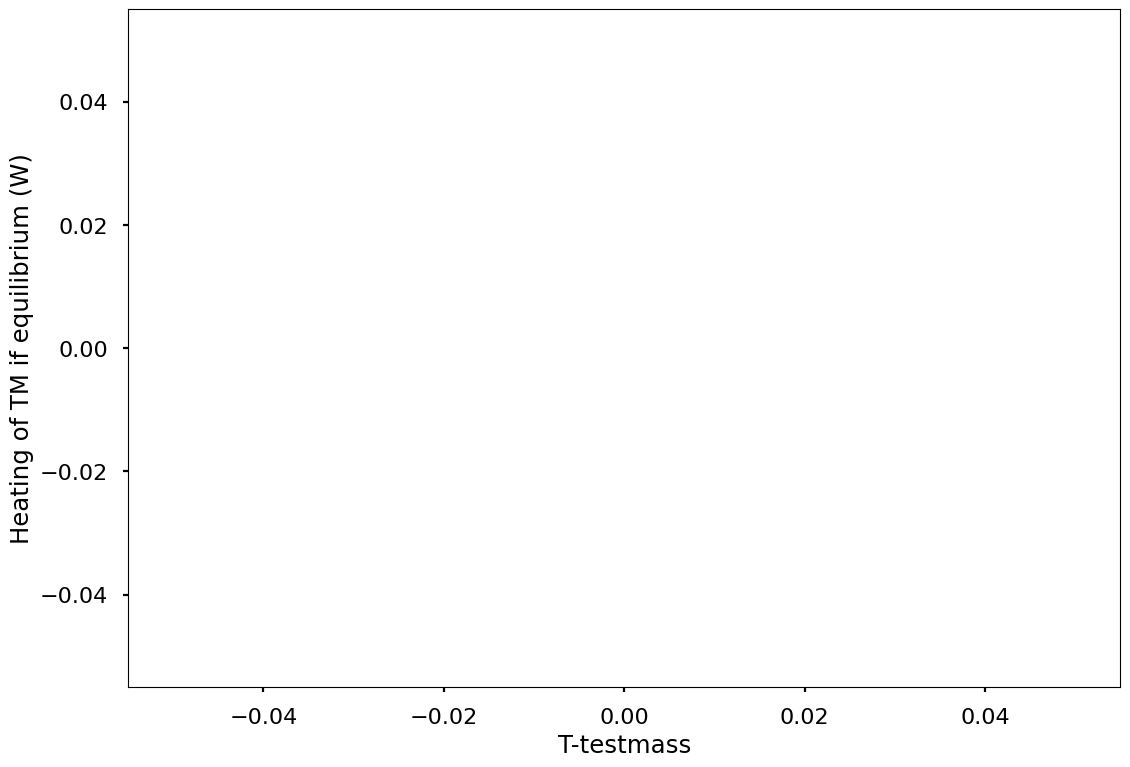

In [12]:
def emissivity(temperature, threshold):
    # return (temperature < threshold) * 0.8 + 0.1
    return 0.5


def cooling_rate_fit(
    T,
    shift,
    emissivity_threshold,
    radiation_scale,
    temperature_environment,
    conduction_scale,
):
    T = T - shift
    # return a + 1 / b * (T + shift) + 1 / d * (T + shift) ** 4  #+ 1/e * (T+shift)**4
    radiation = emissivity(T, emissivity_threshold) * radiation_scale * T**4
    conduction = (T - temperature_environment) * conduction_scale
    return radiation + conduction


def polynomic_fit(T, shift, a, b, c, d):
    T = shift + T
    return a + b * T + d**4


rolling_window = 10
cooling_rate_low = (
    cooling_rate.query("index < 20").query("index > 7.5").rolling(window=rolling_window).median()
)
display(cooling_rate_low)
cooling_rate_low["total heat flux (W)"].plot(
    ylabel="Heating of TM if equilibrium (W)",
    logx=False,
    logy=False,
    # ylim=(0,0.1)
)

# initial_guesses =[-8,-68700,-2e9, -0.01]
# initial_guesses = [7, 40, 1e-8, 8, 1e-24]
popt, pcov = optimize.curve_fit(
    polynomic_fit,
    cooling_rate_low.index[rolling_window:],
    cooling_rate_low["total heat flux (W)"].iloc[rolling_window:],
    # p0=initial_guesses,
    # bounds=([-9, 0, 10, 5e3, 1], [-6, 0.1, 3000, 1e6, 1e10]),
)
# print(*popt)
polynomic_fit(cooling_rate_low.index.to_series(), *popt).plot()

## Conductive heat flux through the teflon screws

The conductive heat flux is calculated with Fourier's law
$$ \vec{q} = -k \nabla T$$

The temperature gradient is simply the difference between TM holder and TM divided by 2 mm.

We have 7 screws, each with a connecting round surface with radius $d=0.5$mm

Therefore:
$$ P_\text{conduction} = -7 r^2 \pi k(T) \nabla T$$
with the temperature dependent thermal conductivity $k(T)$

In [99]:
radius_screw_tip = 0.3e-3
factor = -7 * (radius_screw_tip) ** 2 * np.pi
cooling_rate["T diff between frame and TM"] = cooling_rate.index - cooling_rate["T-coldframe"]
cooling_rate["nabla T"] = cooling_rate["T diff between frame and TM"] / 2e-3
cooling_rate["conductive heat flux (W)"] = (
    factor * teflon.heat_conductivity(cooling_rate["T-coldframe"]) * cooling_rate["nabla T"]
)
display(cooling_rate)

KeyError: 'T-coldframe'

In [ ]:
def gray_body_thermal_radiation(emissivity, temperature, surface_area):
    return emissivity * const.Stefan_Boltzmann * surface_area * temperature**4

In [ ]:
((cooling_rate["total heat flux (W)"]).plot(xlim=[6, 100], label="total"))
((cooling_rate["total heat flux (W) average"]).plot(xlim=[6, 100], label="total rolling average"))
(
    (cooling_rate["conductive heat flux (W)"]).plot(
        xlim=[6, 100], ylim=[-0.04, 0], label="conduction"
    )
)
surface_area = 0.0998 * (2.54 / 200) ** 2 * np.pi
cooling_rate["radiation (W)"] = (
    -gray_body_thermal_radiation(1, cooling_rate.index, surface_area)
) * 80
(cooling_rate["radiation (W)"]).plot(label="radiation")
cooling_rate["total simulated (W)"] = (
    cooling_rate["radiation (W)"] + cooling_rate["conductive heat flux (W)"]
)
cooling_rate["total simulated (W)"].plot()
plt.ylabel("Heat flux (W)")

plt.legend()

# Cooling by radiation (fitting the emissivity)

*Gray body radiation* is given by
$$
P_\text{radiation} = \epsilon \sigma A T^4$$
with the emissivity $\epsilon$, Stefan Boltzmann Constant $\sigma$, surface area $A$ and temperature $T$

In [ ]:
# cooling_rate["radiation (W)"] = cooling_rate["total heat flux (W) average"] - cooling_rate["conductive heat flux (W)"]
# cooling_rate["emissivity"] = cooling_rate["radiation (W)"] / (surface_area * const.Stefan_Boltzmann * cooling_rate.index**(1/4))

In [ ]:
cooling_rate["radiation (W)"].plot()
((cooling_rate["total heat flux (W)"]).plot(xlim=[6, 300], label="total"))

0

In [7]:
from gascooling.accommodation.evaluation.experiment.materials import teflon
import numpy as np

deltaT = 25
conduction = (
    7  # screws
    * 0.3e-3**2  # radius squared
    * np.pi
    * teflon.heat_conductivity((deltaT + 8 * 2) / 2)
    * deltaT
    / 2e-3  # mm distance
)
conduction * 1000

3.563948863304032